# Train on all patients
## Leave One Out

In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap
import xgboost as xgb
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler
import joblib
import math

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

extension = 'csv'
path = 'C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/'
model_name = 'brazil_model_features_new_3.json'

patients_dirs = [x[0] for x in os.walk(path)]
del patients_dirs[0]

# Initialize the classifier
model = XGBClassifier(n_estimators=100, objective='binary:logistic',
                          eval_metric='logloss', subsample=0.6, max_depth=3, learning_rate=0.1, colsample_bytree=1.0)

# List to store accuracies
accuracies = []
best_accuracy = 0
best_fold = 0
best_model = None  # To hold the best model
cols = ["std_mr", "std_ml", "var_mr", "var_ml", "rms_mr",
        "rms_ml", "mav_mr", "mav_ml", "log_det_mr", "log_det_ml", "wl_mr", "wl_ml",
        "aac_mr", "aac_ml", "dasdv_mr", "dasdv_ml", "wamp_mr",
        "wamp_ml", "fr_mr", "fr_ml", "mnp_mr", "mnp_ml", "tot_mr", "tot_ml", "mnf_mr",
        "mnf_ml", "mdf_mr", "mdf_ml", "pkf_mr", "pkf_ml", "HRV_mean", "HRV_median", 
        "HRV_sdnn", "HRV_min", "HRV_max", "HRV_vhf", "HRV_lf", "HRV_hf", "HRV_lf_hf", "RRI"]

# Leave-One-Patient-Out Cross-Validation
for i, test_file in enumerate(patients_dirs):
    # Leave one patient out (this will be the test set)
    patient_nr = test_file[-1]
    os.chdir(test_file)
    csv_file = f"./p{patient_nr}_features.csv"
    test_data = pd.read_csv(csv_file)

    X_test = test_data[cols]
    y_test = test_data[["y"]]
    
    # Combine the rest of the files into the training set
    X_train_list = []
    y_train_list = []
    
    for j, train_file in enumerate(patients_dirs):
        if j != i:  # Exclude the current test patient file
            patient_nr = train_file[-1]
            os.chdir(train_file)
            train_file = f"./p{patient_nr}_features.csv"
            train_data = pd.read_csv(train_file)

            X = train_data[cols]
            y = train_data[["y"]]

            X_train_list.append(X)  # Features
            y_train_list.append(y)  # Labels
    
    # Concatenate training data from all patients except the test patient
    X_train = pd.concat(X_train_list, ignore_index=True)
    y_train = pd.concat(y_train_list, ignore_index=True)

    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy for this fold and store it
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold {i+1}: Test File = {test_file}, Accuracy = {acc:.4f}")

    # Check if this fold's accuracy is the best we've seen
    if acc > best_accuracy:
        best_accuracy = acc
        best_fold = i + 1
        best_model = model  # Save the model for this fold

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f'\nOverall Mean Accuracy (Leave-One-Patient-Out): {mean_accuracy:.4f}')
print(f'Best Fold: {best_fold} with Accuracy: {best_accuracy:.4f}')

# Save the best model
if best_model is not None:
    best_model.save_model(f"C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/{model_name}")


Fold 1: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 1, Accuracy = 0.9971
Fold 2: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 2, Accuracy = 0.9990
Fold 3: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 3, Accuracy = 0.9956
Fold 4: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 4, Accuracy = 0.9984
Fold 5: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 5, Accuracy = 0.9977
Fold 6: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 6, Accuracy = 0.9989
Fold 7: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 7, Accuracy = 0.9870
Fold 8: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 8, Accuracy = 0.9923

Overall Mean Accuracy (Leave-One-Patient-Out): 0.9957
Best Fold: 2 with Accuracy: 0.9990


In [5]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 500),  # Randomly sample from 100 to 500
    'max_depth': randint(3, 10),  # Randomly sample from 3 to 10
    'learning_rate': uniform(0.01, 0.3),  # Randomly sample from 0.01 to 0.3
    'subsample': uniform(0.7, 0.3),  # Randomly sample from 0.7 to 1.0
    'colsample_bytree': uniform(0.7, 0.3)  # Randomly sample from 0.7 to 1.0
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, 
                                   n_iter=50, cv=3, scoring='accuracy', verbose=1, random_state=42)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best hyperparameters from random search
print("Best parameters found: ", random_search.best_params_)

# Evaluate on the test data
y_pred = random_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:13:02] WAR

Best parameters found:  {'colsample_bytree': 0.8834959481464842, 'learning_rate': 0.012119891565915222, 'max_depth': 3, 'n_estimators': 148, 'subsample': 0.8574323980775167}
Accuracy: 0.9990


In [32]:
extension = 'csv'
path = 'C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/'
model_name = 'brazil_model_features_new_2.json'

patients_dirs = [x[0] for x in os.walk(path)]
del patients_dirs[0]

# Initialize the classifier
model = XGBClassifier(n_estimators=100, objective='binary:logistic',
                          eval_metric='logloss', subsample=0.6, max_depth=3, learning_rate=0.1, colsample_bytree=1.0)

# List to store accuracies
accuracies = []
cols = ["std_mr", "std_ml", "var_mr", "var_ml", "rms_mr",
               "rms_ml", "mav_mr", "mav_ml", "log_det_mr", "log_det_ml", "wl_mr", "wl_ml",
               "aac_mr", "aac_ml", "dasdv_mr", "dasdv_ml", "wamp_mr",
               "wamp_ml", "fr_mr", "fr_ml", "mnp_mr", "mnp_ml", "tot_mr", "tot_ml", "mnf_mr",
               "mnf_ml", "mdf_mr", "mdf_ml", "pkf_mr", "pkf_ml", "HRV_mean", "HRV_median", 
               "HRV_sdnn", "HRV_min", "HRV_max", "HRV_vhf", "HRV_lf", "HRV_hf", "HRV_lf_hf", "RRI"]


# Leave-One-Patient-Out Cross-Validation
for i, test_file in enumerate(patients_dirs):
    # Leave one patient out (this will be the test set)
    patient_nr = test_file[-1]
    os.chdir(test_file)
    csv_file = f"./p{patient_nr}_features.csv"
    test_data = pd.read_csv(csv_file)

    X_test = test_data[cols]
    y_test = test_data[["y"]]
    
    # Combine the rest of the files into the training set
    X_train_list = []
    y_train_list = []
    
    for j, train_file in enumerate(patients_dirs):
        if j != i:  # Exclude the current test patient file
            patient_nr = train_file[-1]
            os.chdir(train_file)
            train_file = f"./p{patient_nr}_features.csv"
            train_data = pd.read_csv(train_file)

            X = train_data[cols]
            y = train_data[["y"]]

            X_train_list.append(X)  # Features
            y_train_list.append(y)  # Labels
    
    # Concatenate training data from all patients except the test patient
    X_train = pd.concat(X_train_list, ignore_index=True)
    y_train = pd.concat(y_train_list, ignore_index=True)

    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy for this fold and store it
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold {i+1}: Test File = {test_file}, Accuracy = {acc:.4f}")

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f'\nOverall Mean Accuracy (Leave-One-Patient-Out): {mean_accuracy:.4f}')

# Save the model
model.save_model(f"C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/{model_name}")


Fold 1: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 1, Accuracy = 0.9971
Fold 2: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 2, Accuracy = 0.9990
Fold 3: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 3, Accuracy = 0.9956
Fold 4: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 4, Accuracy = 0.9984
Fold 5: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 5, Accuracy = 0.9977
Fold 6: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 6, Accuracy = 0.9989
Fold 7: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 7, Accuracy = 0.9870
Fold 8: Test File = C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/Patient 8, Accuracy = 0.9923

Overall Mean Accuracy (Leave-One-Patient-Out): 0.9957


## Get feature importances

In [33]:
feature_names = ["std_mr", "std_ml", "var_mr", "var_ml", "rms_mr",
               "rms_ml", "mav_mr", "mav_ml", "log_det_mr", "log_det_ml", "wl_mr", "wl_ml",
               "aac_mr", "aac_ml", "dasdv_mr", "dasdv_ml", "wamp_mr",
               "wamp_ml", "fr_mr", "fr_ml", "mnp_mr", "mnp_ml", "tot_mr", "tot_ml", "mnf_mr",
               "mnf_ml", "mdf_mr", "mdf_ml", "pkf_mr", "pkf_ml", "HRV_mean", "HRV_median", 
               "HRV_sdnn", "HRV_min", "HRV_max", "HRV_vhf", "HRV_lf", "HRV_hf", "HRV_lf_hf", "RRI"]


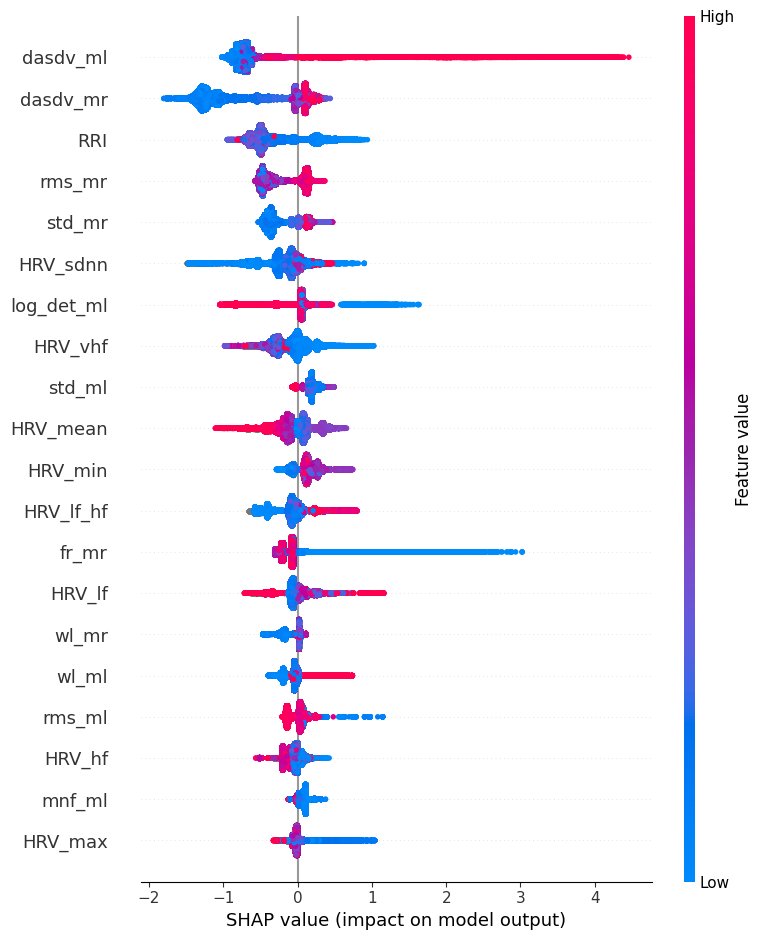

In [34]:
booster = model.get_booster()

dtrain = xgb.DMatrix(X_train)

explainer = shap.TreeExplainer(booster)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=feature_names)

# Predict on ZZM Data

In [38]:
def calculate_hrv(ecg_90s):
    try:
        ecg_clean = nk.ecg_clean(ecg_90s, sampling_rate=200)
        ecg_peaks = nk.ecg_findpeaks(ecg_clean, sampling_rate=200)
        info, r_peaks_corrected = nk.signal_fixpeaks(ecg_peaks, sampling_rate=200, iterative=False, show=False, method="Kubios")
        hrv = nk.hrv(r_peaks_corrected,sampling_rate=200, show=False)
        mean = hrv["HRV_MeanNN"][0]
        median = hrv["HRV_MedianNN"][0]
        sdnn = hrv["HRV_SDNN"][0]
        min = hrv["HRV_MinNN"][0]
        max = hrv["HRV_MaxNN"][0]
        vhf = hrv["HRV_VHF"][0]
        lf = hrv["HRV_LF"][0]
        hf = hrv["HRV_HF"][0]
        lf_hf = hrv["HRV_LFHF"][0]


        return mean, median, sdnn, min, max, vhf, lf, hf, lf_hf
    except:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def spectrum(signal, sampling_rate):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (sampling_rate / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power


def frequency_ratio(frequency, power):
    power_low = power[(frequency >= 1) & (frequency <= 30)]  # Low range: 1-30 Hz
    power_high = power[(frequency > 30) & (frequency <= 100)]  # High range: 30-100 Hz (up to Nyquist)

    ULC = np.sum(power_low)
    UHC = np.sum(power_high)

    # Avoid division by zero in case the high-frequency power is 0
    if UHC == 0:
        return np.nan
    else:
        return ULC / UHC

def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]
    
    if den == 0:
        return np.nan
    else:
        return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0
    try:
        while abs(errel) > tol:
            temp += power[i]
            errel = (power_total - temp) / power_total
            i += 1
            if errel < 0:
                errel = 0
                i -= 1

        return frequency[i]
    except:
        return np.nan
    
def peak_freq(frequency, power):
    try:
        return frequency[power.argmax()]
    
    except:
        return np.nan


def get_rri(ecg, sampling_rate=200):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_rate)
    ecg_peaks = nk.ecg_findpeaks(ecg_clean, sampling_rate=sampling_rate)
    info, r_peaks_corrected = nk.signal_fixpeaks(ecg_peaks, sampling_rate=sampling_rate, iterative=False, show=False, method="Kubios")

    # Calculate RR intervals
    rr_intervals = np.diff(r_peaks_corrected) / sampling_rate * 1000

    # Insert fake data point
    rr_intervals_adjusted = np.insert(rr_intervals, 0, rr_intervals[0])

    # Calculate time axis
    time_r_peaks = r_peaks_corrected[1:] / sampling_rate  # Time corresponding to the RR intervals
    time_r_peaks_adjusted = np.insert(time_r_peaks, 0, 0)  # Add a time point for the fake interval
    print(time_r_peaks[0])

    rri_adj_df = pd.DataFrame(data={'RRI': rr_intervals_adjusted, 'RRI_t': time_r_peaks_adjusted})

    return rri_adj_df

# Function to populate the RRI column in df_sliding
def extend_df_with_rri(df_sliding, df_rr):
    # Create a new column to store RR intervals
    df_sliding['RRI'] = np.nan  # Placeholder for the new RR interval column
    
    rri_index = 0  # Pointer for the df_rr
    total_rr_rows = len(df_rr)

    for idx in range(len(df_sliding)):
        # Get the current start time of the sliding window
        window_start = df_sliding.at[idx, 'start_time']
        
        # Update the RRI value until we reach the next RRI_t
        while rri_index < total_rr_rows and df_rr.at[rri_index, 'RRI_t'] <= window_start:
            # Populate the RRI value for this window
            df_sliding.at[idx, 'RRI'] = df_rr.at[rri_index, 'RRI']
            rri_index += 1
        
        # If we have reached the end of RRI DataFrame, we can break
        if rri_index >= total_rr_rows:
            break
    
    # Fill any remaining NaN values in the RRI column with the last known value
    df_sliding['RRI'].fillna(method='ffill', inplace=True)
    
    return df_sliding


In [39]:
def extract_features_for_prediction(sensor_data, window_size_emg_s=1, overlap_emg_s=0.5, window_size_ecg_s=90, overlap_ecg_s=45, sampling_rate=200):
    window_size_emg = int(window_size_emg_s * sampling_rate)
    window_size_ecg = int(window_size_ecg_s * sampling_rate)
    overlap_emg = int(overlap_emg_s * sampling_rate)
    overlap_ecg = int(overlap_ecg_s * sampling_rate)

    features_1s = []
    features_90s = []

    scaler_mr = MinMaxScaler(feature_range=(0,100))
    scaler_ml = MinMaxScaler(feature_range=(0,100))

    ecg_data = sensor_data['ECG'].values
    mr_data = pd.DataFrame(scaler_mr.fit_transform(sensor_data[["MR"]]), columns=["MR"])['MR'].values
    ml_data = pd.DataFrame(scaler_ml.fit_transform(sensor_data[["ML"]]), columns=["ML"])['ML'].values
    
    mr_threshold = np.mean(mr_data) + 3 * np.std(mr_data)
    ml_threshold = np.mean(ml_data) + 3 * np.std(ml_data)

    for i in range(window_size_emg, len(sensor_data), overlap_emg):

        # Extract the 1-second window
        mr_window = mr_data[i-window_size_emg:i]
        ml_window = ml_data[i-window_size_emg:i]

        # Standard Deviation
        std_mr = np.std(mr_window)
        std_ml = np.std(ml_window)

        # Variance
        var_mr = np.var(mr_window)
        var_ml = np.var(ml_window)

        # RMS
        rms_mr = np.sqrt(np.mean(mr_window ** 2))
        rms_ml = np.sqrt(np.mean(ml_window ** 2))

        # Mean Absolute Value
        mav_mr = np.mean(np.abs(mr_window))
        mav_ml = np.mean(np.abs(ml_window))

        # Log detector
        log_det_mr = np.mean(np.log(np.maximum(np.absolute(mr_window), 1e-10))) 
        log_det_ml = np.mean(np.log(np.maximum(np.absolute(ml_window), 1e-10)))

        # Wavelength
        wl_mr = np.sum(abs(np.diff(mr_window)))
        wl_ml = np.sum(abs(np.diff(ml_window)))

        # Average Amplitude Change
        aac_mr = np.mean(np.abs(np.diff(mr_window)))
        aac_ml = np.mean(np.abs(np.diff(ml_window)))

        # Difference absolute standard deviation value
        dasdv_mr = math.sqrt((1 / (window_size_emg - 1)) * np.sum((np.diff(mr_window)) ** 2))
        dasdv_ml = math.sqrt((1 / (window_size_emg - 1)) * np.sum((np.diff(ml_window)) ** 2))

        # Willison Amplitude
        wamp_mr = np.sum(np.abs(np.diff(mr_window)) > mr_threshold)
        wamp_ml = np.sum(np.abs(np.diff(ml_window)) > ml_threshold)

        frequency_mr, power_mr = spectrum(mr_window, sampling_rate)
        frequency_ml, power_ml = spectrum(ml_window, sampling_rate)
        
        # Frequency power
        fr_mr =frequency_ratio(frequency_mr, power_mr) 
        fr_ml =frequency_ratio(frequency_mr, power_mr)

        # Mean power
        mnp_mr = np.sum(power_mr) / len(power_mr)
        mnp_ml = np.sum(power_ml) / len(power_ml)

        
        # Total power
        tot_mr = np.sum(power_mr)
        tot_ml = np.sum(power_ml)

        #Mean Frequency
        mnf_mr = mean_freq(frequency_mr, power_mr)
        mnf_ml = mean_freq(frequency_ml, power_ml)

        # Median frequency
        mdf_mr = median_freq(frequency_mr, power_mr)
        mdf_ml = median_freq(frequency_ml, power_ml)

        # Peak frequency
        pkf_mr = peak_freq(frequency_mr, power_mr)
        pkf_ml = peak_freq(frequency_ml, power_ml)

        start_time = (i-window_size_emg) / sampling_rate
        end_time = i / sampling_rate
        
        current_features = [start_time, end_time, std_mr, std_ml, var_mr, var_ml, rms_mr, rms_ml, mav_mr, mav_ml, log_det_mr, log_det_ml, wl_mr, wl_ml, aac_mr, aac_ml, dasdv_mr, dasdv_ml, wamp_mr, wamp_ml, fr_mr, fr_ml, mnp_mr, mnp_ml, tot_mr, tot_ml, mnf_mr, mnf_ml, mdf_mr, mdf_ml, pkf_mr, pkf_ml]
        features_1s.append(current_features)
    

        if i % 10000000 == 0:
            print(f"i: {i}")

    for i in range(window_size_ecg, len(ecg_data), overlap_ecg):
        # Extract 90 seconds of ECG data
        window_90s = ecg_data[i - window_size_ecg:i]  # 90-second window

        mean, median, sdnn, min, max, vhf, lf, hf, lf_hf = calculate_hrv(window_90s)

        num_1s_windows_in_90s = window_size_ecg // window_size_emg
        for _ in range(num_1s_windows_in_90s):
            features_90s.append([mean, median, sdnn, min, max, vhf, lf, hf, lf_hf])


    combined_features = [f1 + f41 for f1, f41 in zip(features_1s, features_90s[:len(features_1s)])]

    columns = ["start_time", "end_time", "std_mr", "std_ml", "var_mr", "var_ml", "rms_mr",
               "rms_ml", "mav_mr", "mav_ml", "log_det_mr", "log_det_ml", "wl_mr", "wl_ml",
               "aac_mr", "aac_ml", "dasdv_mr", "dasdv_ml", "wamp_mr",
               "wamp_ml", "fr_mr", "fr_ml", "mnp_mr", "mnp_ml", "tot_mr", "tot_ml", "mnf_mr",
               "mnf_ml", "mdf_mr", "mdf_ml", "pkf_mr", "pkf_ml", "HRV_mean", "HRV_median", 
               "HRV_sdnn", "HRV_min", "HRV_max", "HRV_vhf", "HRV_lf", "HRV_hf", "HRV_lf_hf"]
    
    features = pd.DataFrame(combined_features, columns=columns)

    rri = get_rri(ecg_data)
    features_rri = extend_df_with_rri(features, rri)
    

    return features_rri




In [36]:
sensor_data = pd.read_csv("C:/Users/eleon/Desktop/SDAP/backend/src/data_resampled/p3_wk3-4/0602473aFnorm200Hz.csv", usecols=['ECG', 'MR', 'ML'])

In [40]:
features = extract_features_for_prediction(sensor_data)

c:\Python311\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python311\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Python311\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for mor

0.915


C:\Users\eleon\AppData\Local\Temp\ipykernel_7144\1112140123.py:132: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sliding['RRI'].fillna(method='ffill', inplace=True)
C:\Users\eleon\AppData\Local\Temp\ipykernel_7144\1112140123.py:132: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sliding['RRI'].fillna(method='ffill', inplace=True)


In [41]:
features

,start_time,end_time,std_mr,std_ml,var_mr,var_ml,rms_mr,rms_ml,mav_mr,mav_ml,...,HRV_mean,HRV_median,HRV_sdnn,HRV_min,HRV_max,HRV_vhf,HRV_lf,HRV_hf,HRV_lf_hf,RRI
0,0.0,1.0,1.298968,2.634885,1.687319,6.942617,45.530939,39.244646,45.512406,39.156093,...,551.759259,545.0,25.878792,500.0,630.0,0.001956,0.036824,0.044691,0.823963,555.0
1,0.5,1.5,0.690175,0.442480,0.476342,0.195789,45.517036,39.197544,45.511803,39.195046,...,551.759259,545.0,25.878792,500.0,630.0,0.001956,0.036824,0.044691,0.823963,555.0
2,1.0,2.0,1.301508,4.344213,1.693923,18.872188,45.534053,39.536499,45.515449,39.297106,...,551.759259,545.0,25.878792,500.0,630.0,0.001956,0.036824,0.044691,0.823963,555.0
3,1.5,2.5,1.158278,4.442170,1.341607,19.732871,45.511720,39.592117,45.496979,39.342126,...,551.759259,545.0,25.878792,500.0,630.0,0.001956,0.036824,0.044691,0.823963,555.0
4,2.0,3.0,0.212594,1.418408,0.045196,2.011880,45.494390,39.264948,45.493893,39.239321,...,551.759259,545.0,25.878792,500.0,630.0,0.001956,0.036824,0.044691,0.823963,555.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67765,33882.5,33883.5,0.017890,0.027357,0.000320,0.000748,45.501312,39.193409,45.501308,39.193399,...,656.259259,710.0,88.645947,530.0,780.0,0.000038,0.001790,0.000894,2.003603,740.0
67766,33883.0,33884.0,0.020747,0.026255,0.000430,0.000689,45.502310,39.193969,45.502305,39.193960,...,656.259259,710.0,88.645947,530.0,780.0,0.000038,0.001790,0.000894,2.003603,710.0
67767,33883.5,33884.5,0.021546,0.022740,0.000464,0.000517,45.502304,39.193324,45.502299,39.193317,...,656.259259,710.0,88.645947,530.0,780.0,0.000038,0.001790,0.000894,2.003603,710.0
67768,33884.0,33885.0,0.022950,0.024972,0.000527,0.000624,45.501551,39.194112,45.501546,39.194104,...,656.259259,710.0,88.645947,530.0,780.0,0.000038,0.001790,0.000894,2.003603,700.0


In [42]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model(f"C:/Users/eleon/Desktop/SDAP/backend/src/data_brazil/{model_name}")

In [43]:
times = features.iloc[:, 0:2]
features = features.iloc[:, 2:42]

In [45]:
y_pred = loaded_model.predict(features)  

y_pred_proba = loaded_model.predict_proba(features)  # Probabilities for each class

print(f"Predicted class labels for new data: {y_pred}")

print(f"Predicted probabilities for new data: {y_pred_proba}")


Predicted class labels for new data: [0 0 0 ... 0 0 0]
Predicted probabilities for new data: [[9.9864900e-01 1.3509857e-03]
 [9.9910462e-01 8.9536561e-04]
 [9.9092585e-01 9.0741273e-03]
 ...
 [9.9870962e-01 1.2903737e-03]
 [9.9850225e-01 1.4977347e-03]
 [9.9870962e-01 1.2903737e-03]]


In [46]:
unique, counts = np.unique(y_pred, return_counts=True)

In [47]:
dict(zip(unique, counts))

{0: 67705, 1: 65}